![MOSEK ApS](https://mosek.com/files/mosek_logo_color.png )


----------------------------------------------------------------------------


Portfolio Optimization
========================


The basic model
---------------------------

The classical *Markowitz portfolio optimization* problem considers investing in $n$ stocks or assets held over a period of time. Let $x_j$ denote the amount invested in asset $j$, and assume a stochastic model where the return of the assets is a random variable $r$ with known mean 

\begin{equation}
   \mu = \mathbf{E} r
\end{equation}

and covariance

\begin{equation}
 \Sigma = \mathbf{E}(r-\mu)(r-\mu)^T.
\end{equation}

The return of the investment is also a random variable $y = r^Tx$ with mean (or expected return)

\begin{equation}
  \mathbf{E} y = \mu^T x
\end{equation}

and variance (or risk)

\begin{equation}
 \mathbf{E}(y - \mathbf{E} y)^2 = x^T \Sigma x.
\end{equation}

The problem facing the investor is to rebalance the portfolio to achieve a good compromise between risk and expected return, e.g., maximize the expected return subject to a budget constraint and an upper bound (denoted $\gamma$) on the tolerable risk.

The variables $x$ denotes the investment i.e. $x_j$ is the amount invested in asset $j$ and $x_j^0$ is the initial holding of asset $j$. Finally, $w$ is the initial amount of cash available. 

Since $e$ is the vector of all ones then $e^T x = \sum_{j=1}^n x_j$ is the total investment. Clearly, the total amount invested must be equal to the initial wealth, i.e. $ w + e^T x^0.$. This leads to the first constraint

\begin{equation}
e^T x = w + e^T x^0.
\end{equation}

The second constraint

\begin{equation}
 x^T \Sigma x \leq \gamma^2
 \end{equation}
 
ensures that the variance, or the risk, is bounded by the parameter $\gamma^2$. Therefore, $\gamma$ specifies an upper bound of the standard deviation the investor is willing to undertake. Finally, the constraint


\begin{equation}
x_j \geq 0
\end{equation}

excludes the possibility of short-selling. This constraint can of course be excluded if short-selling is allowed.

The optimization problem takes the form

\begin{equation}
   \begin{array}{llll}
   \mbox{maximize}   & \mu^T x       &        &\\
   \mbox{subject to} &  e^T x        & =      & w + e^T x^0,\\
                     &  x^T \Sigma x & \leq   & \gamma^2,\\
                     &  x            & \geq 0.& 
   \end{array}
\end{equation}


A popular choice is $x^0 = 0$ and $w=1$ because then $x_j$ may be interpretated as the relative amount of the total portfolio that is invested in asset $j$.

The covariance matrix $\Sigma$ is positive semidefinite by definition and therefore there exist a matrix $G$ such that


\begin{equation}
   \Sigma = G G^T.
\end{equation}
 
In general the choice of $G$ is **not** unique and one possible choice of $G$ is the Cholesky factorization of $\Sigma$. However, in many cases another choice is better for efficiency reasons. For a given $G$ we have that


\begin{equation}
   \begin{array}{lll}
   x^T \Sigma x & = & x^T G G^T x \\
                & = & \left\|G^T x\right\|^2.
   \end{array}
\end{equation}

Hence, we may write the risk constraint as

\begin{equation}
   \gamma \geq \left\|G^T x\right\|
\end{equation}

or equivalently

\begin{equation}
 \left[\gamma;G^T x\right] \in Q^{n+1}.
\end{equation}

where $Q^{n+1}$ is the $n+1$ dimensional quadratic cone. Therefore, problem can be written as

\begin{equation}
   \begin{array}{llll}
    \mbox{maximize}   & \mu^T x             &      & \\
    \mbox{subject to} &  e^T x              & =    & w+e^T x^0,\\
                      & [\gamma;G^T x]      & \in  & Q^{n+1},\\
                      &  x                  & \geq & 0,
   \end{array}
\end{equation}

which is a conic quadratic optimization problem that can easily be formulated and solved with `fusion`. 

here is the implementation using `Fusion`:

In [33]:
from mosek.fusion import *

def BasicMarkowitz(mu,GT,w,gamma):
    

    with  Model("Basic Markowitz") as M:

        n = len (mu)
        
        x = M.variable('x', n, Domain.greaterThan(0.0))

        M.objective('obj', ObjectiveSense.Maximize, Expr.dot(mu,x))

        M.constraint('budget', Expr.sum(x), Domain.equalsTo(w))

        M.constraint('risk', Expr.vstack( gamma,Expr.mul(GT,x)), Domain.inQCone())

        M.solve()

        return x.level()

We need some input. For sake of simplicity we use a small example, and 

In [31]:
n  = 3

mu = [0.1073, 0.0737, 0.0627]
x0 = [0.0 for i in range(n)]
w  = 1.0

Sigma = [\
    [0.02778 ,   0.00387 ,  0.00021],\
    [0.00387 ,   0.01112 , -0.00020],\
    [0.00021 ,  -0.00020 ,  0.00115] \
    ]

gamma = 0.15

def dot(a,b):
    return sum([aa*bb for aa,bb in zip(a,b)])


def print_mat(M):
    for i in range(len(M)):
        print "| %s |" % ','.join(['%+.4f'%M[i][j] for j in range(n)])

The Cholesky factor of $\Sigma$ can be easily computed. 

We use the built-in `LAPACK potrf` function provided by MOSEK optimizer API:

In [32]:
import mosek as msk

GT=[]

with msk.Env() as env:
    ll=[ c for r in Sigma for c in r]
    env.potrf( msk.uplo.lo,n, ll)
    
    GT = [ [0.]*i + ll[i*n+i:(i+1)*n] for i in range(n)]
    
print_mat(GT)


| +0.1667,+0.0232,+0.0013 |
| +0.0000,+0.1029,-0.0022 |
| +0.0000,+0.0000,+0.0338 |


The model can be easily implemented in `fusion`:

The function is almost self-explanatory. 



x = BasicMarkowitz(mu,GT,w,gamma)
print "x = ",x
print 'expected return = %f'% dot(mu,x)

The efficient frontier
-------------------------

The portfolio computed by the Markowitz model is efficient in the sense that there no other other portfolio giving a strictly higher return for the same amount of risk. An efficient portfolio is also sometimes called a Pareto optimal portfolio. Clearly, an investor should only invest in efficient portfolios and therefore it may be relevant to present the investor for all efficient portfolios so the investor can choose the portfolio that has the desired tradeoff between return and risk. 

Given a nonnegative $\alpha$ then the problem 

\begin{equation}
   \begin{array}{lll}
   \mbox{maximize}   & \mu^T x - \alpha s& \\
   \mbox{subject to} &  e^T x            & =     w + e^T x^0,\\
                     &  [s;G^T x]        & \in   Q^{n+1},\\
                     &  x                & \geq  0.
   \end{array}
\end{equation}

computes an efficient portfolio. Note that the objective maximize the expected return while maximizing $-\alpha$ times the standard deviation. Hence, the standard deviation is minimized while $\alpha$ specifies the tradeoff between expected return and risk. Ideally the problem  should be solved for all values $\alpha \geq 0$ but in practice impossible.

In [38]:
def EfficientFrontier(mu,GT,x0,w,alphas):
    
    n = len(mu)
    
    with Model("Efficient frontier") as M:

        # Defines the variables (holdings). Shortselling is not allowed.
        x = M.variable("x", n, Domain.greaterThan(0.0)) # Portfolio variables
        s = M.variable("s", 1, Domain.unbounded()) # Risk variable

        M.constraint('budget', Expr.sum(x), Domain.equalsTo(w+sum(x0)))

        M.constraint('risk', Expr.vstack(s,Expr.mul(GT,x)),Domain.inQCone())

        risk = []
        ret  = []
        xs = []
        
        mudotx = Expr.dot(mu,x)
        for i,alpha in enumerate(alphas):

            #  Define objective as a weighted combination of return and risk
            M.objective('obj', ObjectiveSense.Maximize, Expr.sub(mudotx,Expr.mul(alpha,s)))

            M.solve()

            risk.append(s.level()[0])
            xs.append(x.level())
            
        return risk,xs

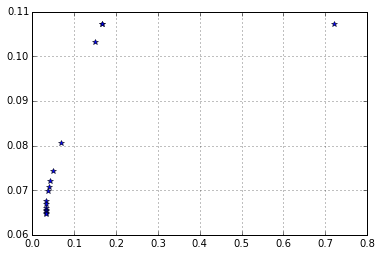

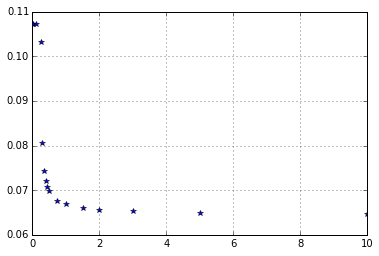

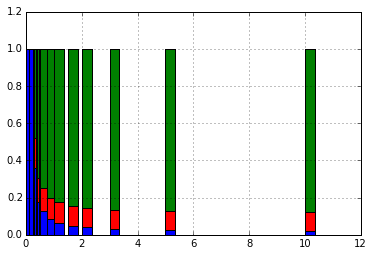

In [44]:
alphas = [0.00, 0.01, 0.10, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.75, 1.00, 1.50, 2.00, 3.00, 5.00, 10.00]

risk,xs = EfficientFrontier(mu,GT,x0,w,alphas)

%matplotlib inline
import matplotlib.pyplot as plt

m = len(alphas)

plt.plot( risk, [ dot(mu,xx) for xx in xs], 'b*')
    
plt.grid()    
plt.show()


plt.plot( alphas, [ dot(mu,xx) for xx in xs], 'b*')
    
plt.grid()    
plt.show()

indx= range(len(alphas))
colors=['b','r','g']
bott = [0. for i in range(m)]

for i in range(n):
    xx = [ xs[j][i] for j in range(m)]
    plt.bar(alphas, xx ,  0.35, bottom=bott,color=colors[i])
    bott= [ bott[j] + xx[j] for j in range(m)]

plt.grid()
plt.show()

Improving the computational efficiency
--------------------------------------


In practice it is often important to solve the portfolio problem in a short amount of time. 

The computational cost is 

* to some extent dependent on the number of constraints and variables,
* in practice a more important factor is the number nonzeros used to represent the problem. 

Indeed it is often better to focus at the number of nonzeros in $G$ and try to reduce that number by for instance changing the choice of $G$. As an example assume that

\begin{equation}
    \Sigma = D + VV^T
\end{equation}

where $D$ is a positive definite diagonal matrix. Moreover, $V$ is a matrix with $n$ rows and $p$ columns. Such a model for the covariance matrix is called a factor model \index{factor model} and usually $p$ is much smaller than $n$. In practice $p$ tends be a small number independent of $n$ say less than 100.

One possible choice for $G$ is the Cholesky factorization of $\Sigma$ which requires storage proportional to $n(n+1)/2$. However, another choice is

\begin{equation}
        G^T = 
        \left[
        \begin{array}{c}
         D^{1/2}
         V^T
        \end{array}
        \right]
\end{equation}

because then $GG^T  = D + VV^T$.

This choice requires storage proportional to $n+pn$ which is much less than for the Cholesky choice of $G$. Indeed assuming $p$ is a constant then the difference in storage requirements is a factor of $n$.

The example above exploits the so-called factor structure and demonstrates that an alternative choice of $G$ may lead to a significant reduction in the amount of storage used to represent the problem. This will in most cases also lead to a significant reduction in the solution time. 

Let's see an example.

The lesson to be learned is that it is important to investigate how the covariance is formed. Given this knowledge it might be possible to make a special choice for $G$ that helps reducing the storage requirements and enhance the computational efficiency.

In [69]:
from mosek.fusion import *

def FactorMarkowitz(n,p,mu,D,H,w,gamma):
    

    with  Model("Basic Markowitz") as M:

        x = M.variable('x', n, Domain.greaterThan(0.0))
        y = M.variable('y', p, Domain.unbounded())

        M.objective('obj', ObjectiveSense.Maximize, Expr.dot(mu,x))

        M.constraint('budget', Expr.sum(x), Domain.equalsTo(w))

        GT = Matrix.diag( D+([1.0]*p))
        M.constraint('risk', Expr.vstack( gamma,Expr.mul(GT, Variable.vstack(x,y))), Domain.inQCone())
        
        M.constraint(Expr.sub(Expr.mul(DenseMatrix(H).transpose(),x),y), Domain.equalsTo(0.))
        M.setLogHandler(open('dump.log','w'))   
        M.writeTask('dump.opf')
        M.solve()

        return None#x.level()

In [70]:
D= [ 0.1, 0.3, 0.6]
H= [[1., 0.],\
    [1., 0.],\
    [0., 1.]]
p=2
    
xx = FactorMarkowitz(n,p,mu,D,H,1.,0.1)


*Disclaimer*
The code in this tutorial is provided as is. Future versions of MOSEK and `Fusion` may be not fully compatible. 

The material is covered by ...

In [71]:
!cat dump.log


Open file 'dump.opf'
Start writing.
done writing. Time: 0.00

Computer
  Platform               : Linux/64-X86    
  Cores                  : 2               

Problem
  Name                   : Basic Markowitz 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 9               
  Cones                  : 1               
  Scalar variables       : 11              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Conic interior-point optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Eliminator - elim's                 : 0               
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Preso

In [72]:
!cat dump.opf


[comment]
   Written by MOSEK version 7.1.0.31
   Date 22-06-15
   Time 22:15:30
[/comment]

[problemname]Basic Markowitz[/problemname]

[hints]
  [hint NUMVAR] 11 [/hint]
  [hint NUMCON] 9 [/hint]
  [hint NUMANZ] 19 [/hint]
  [hint NUMQNZ] 0 [/hint]
  [hint NUMCONE] 1 [/hint]
[/hints]

[variables disallow_new_variables]
  'x[0]' 'x[1]' 'x[2]' 'y[0]' 'y[1]' 
  'risk[0].coneslack' 'risk[1].coneslack' 'risk[2].coneslack' 'risk[3].coneslack' 'risk[4].coneslack' 
  'risk[5].coneslack' 
[/variables]

[objective maximize 'obj']
   1.073e-01 'x[0]' + 7.37e-02 'x[1]' + 6.270000000000001e-02 'x[2]'
[/objective]

[constraints]
  [con 'c0000_budget[0]']  'x[0]' + 'x[1]' + 'x[2]' = 1e+00 [/con]
  [con 'c0001_risk[0]']  - 'risk[0].coneslack' = -1e-01 [/con]
  [con 'c0002_risk[1]']  1e-01 'x[0]' - 'risk[1].coneslack' = 0e+00 [/con]
  [con 'c0003_risk[2]']  3e-01 'x[1]' - 'risk[2].coneslack' = 0e+00 [/con]
  [con 'c0004_risk[3]']  6e-01 'x[2]' - 'risk[3].coneslack' = 0e+00 [/con]
  [con 'c0005_risk[4